# Gonads - PGCs palantir analysis

In [1]:
import palantir
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import os
import operator
import matplotlib.pyplot as plt

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_germcells/'
# sc.logging.print_versions()
# sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable
plt.show()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Load and merge mouse datsets

In [2]:
adataGC = sc.read('/nfs/team292/vl6/Mouse_Sanger/germcells_all2.h5ad')

In [3]:
set(adataGC.obs.dataset)

{'Mayere2021', 'Niu2020', 'Sanger'}

In [4]:
adata = anndata.AnnData(X=adataGC.raw.X, var=adataGC.raw.var, obs=adataGC.obs, asview=False)

In [5]:
# Add old cluster subname
cell_annot = adataGC.obs['germcells_annotation'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')

In [6]:
adata.obsm['X_umap'] = adataGC.obsm['X_umap']
adata.obsm['X_scVI'] = adataGC.obsm['X_scVI']
adata.obsp['connectivities'] = adataGC.obsp['connectivities']
adata.obsp['distances'] = adataGC.obsp['distances']
# adata.uns['celltype_colors'] = adataGC.uns['celltype_colors']
adata.uns['neighbors'] = adataGC.uns['neighbors']

In [7]:
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
sc.pp.filter_cells(adata, min_genes=1000)
adata.obs['celltype'].value_counts()

filtered out 25 cells that have less than 1000 genes expressed


Trying to set attribute `.obs` of view, copying.


oogonia_STRA8        3209
oogonia_meiotic      2063
GC_male              1577
GC_female            1406
PGC                   964
pre_oocyte            681
pre_spermatogonia     280
oocyte                206
Name: celltype, dtype: int64

In [8]:
adata.obs.at[adata.obs['dataset'] == 'Niu2020', 'sex'] = 'female'

In [9]:
print(pd.__version__)

1.1.5


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


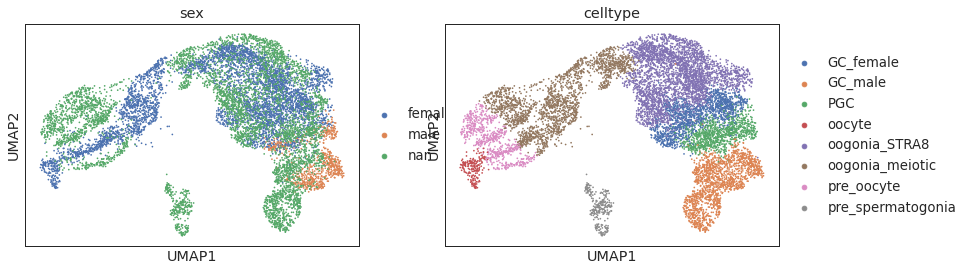

In [10]:
%matplotlib inline
sc.pl.umap(adata, color=['sex', 'celltype'])

## Downsample

In [11]:
target_cells = 150

adata.obs['cell'] = adata.obs.index
adata.obs['sex_fake'] = [ '--'+str(i)+'--' for i in adata.obs['celltype'].tolist() ] # this is ensure perfect match
adata.obs['sex_fake'] = adata.obs['sex_fake'].astype('category')
#adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)

adatas = [adata[adata.obs['sex_fake'].isin([cl])] for cl in adata.obs['sex_fake'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells, random_state=0)

adata_downsampled = adatas[0].concatenate(*adatas[1:])

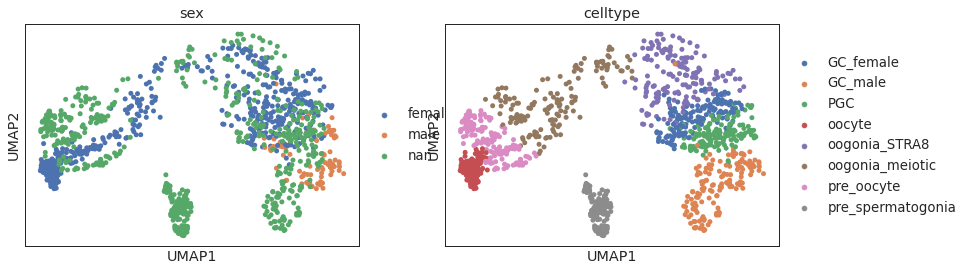

In [12]:
adata = adata[[ i in adata_downsampled.obs.cell.tolist() for i in adata.obs['cell'] ]]
adata
sc.pl.umap(adata, color=['sex', 'celltype'])

In [13]:
adata.obs['celltype'].value_counts()

pre_spermatogonia    150
pre_oocyte           150
oogonia_meiotic      150
oogonia_STRA8        150
oocyte               150
PGC                  150
GC_male              150
GC_female            150
Name: celltype, dtype: int64

## Find root cell

In [14]:
index, value = max(enumerate(adata[:,'Nanog'].X), key=operator.itemgetter(1))
start_cell = adata.obs.index[index]
start_cell

'HCA_Mou_10827183_GAGGTGACACCAGGCT-male-Sanger'

Trying to set attribute `.uns` of view, copying.
<ipython-input-15-5499882dabf7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][index] = 1


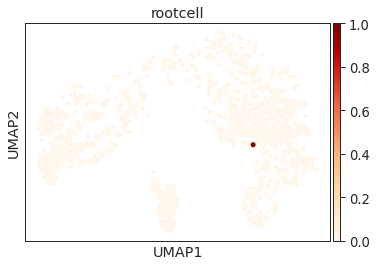

In [15]:
adata.uns['iroot'] = index
adata.obs['rootcell'] = 0
adata.obs['rootcell'][index] = 1

sc.pl.umap(adata,color='rootcell',color_map='OrRd')

In [16]:
start_cell

'HCA_Mou_10827183_GAGGTGACACCAGGCT-male-Sanger'

## Run diffusion map
Determine the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [17]:
# sc.tl.diffmap(adata)
# sc.tl.dpt(adata, n_branchings=2, n_dcs=15)

## Run palantir

In [18]:
# ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
# pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, knn=30)
# adata.obs['palantir_pseudotime'] = pr_res.pseudotime

## Visualize

In [19]:
# sc.pl.umap(adata, color=['stage',  'sex', 'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1', 'SYCP1', 'FIGLA', 'PIWIL4', 'PIWIL4', 'percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

In [20]:
# sc.pl.diffmap(adata, color=['stage',  'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1','STRA8', 'SYCP1', 'FIGLA', 'PIWIL4','percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

## Gene expression - palantir

#### Generate the norm expression matrix

In [21]:
adata_count = adata.copy()
sc.pp.filter_genes(adata_count, min_counts=10)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
sc.pp.highly_variable_genes(adata_count, n_top_genes=2000)

m = adata_count.X.toarray()
norm_df = pd.DataFrame(data=m, index=adata_count.obs_names, columns=adata_count.var_names)

sc.pp.scale(adata_count)


filtered out 2794 genes that are detected in less than 10 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


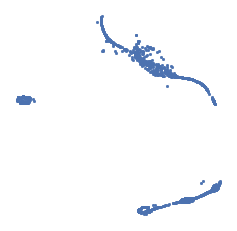

In [22]:
# pca_projections, _ = palantir.utils.run_pca(adata_count)
pca_projections = pd.DataFrame(adata.obsm["X_scVI"])
pca_projections.index = adata.obs_names
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
tsne = palantir.utils.run_tsne(ms_data)
fig, ax = palantir.plot.plot_tsne(tsne)

#### Impute with MAGIC

In [23]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

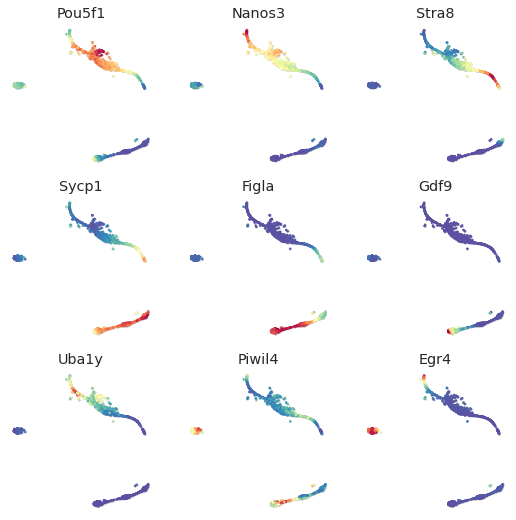

In [24]:
genes = ['Pou5f1', 'Nanos3',  'Stra8', 'Sycp1', 'Figla', 'Gdf9','Uba1y', 'Piwil4', 'Egr4']
palantir.plot.plot_gene_expression(imp_df, tsne, genes, n_cols=3)
fig = plt.gcf()
fig.savefig('plot_gene_expression.pdf', dpi=1200)

#### Run diffusion

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


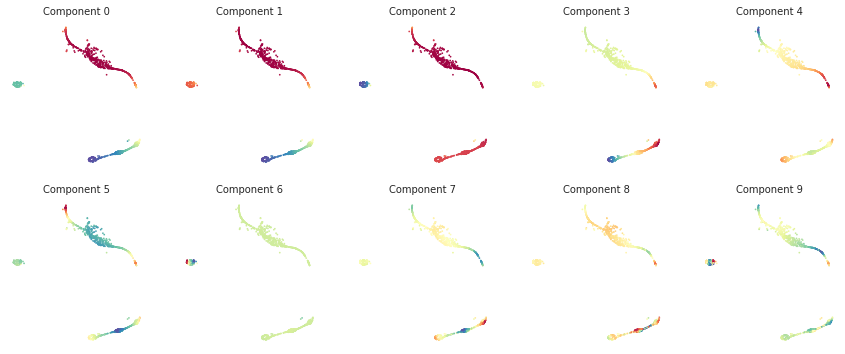

In [25]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

#### Rename terminal states to reflect the known biology below

In [26]:
start_cell

'HCA_Mou_10827183_GAGGTGACACCAGGCT-male-Sanger'

In [27]:
# obtain pr_res object
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0009220798810323079 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.04685247739156087 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [28]:
pr_res.branch_probs.columns

Index(['170712_T_E16:CCTTCGAGTATAAACGx-Mayere2021', 'GSM4643738_P5ovary_TGGGAAGAGAAGATTC-Niu2020'], dtype='object')

In [29]:
# adata.obs['branch_1'] = [i in pr_res.branch_probs.columns[0] for i in adata.obs_names ]
# adata.obs['branch_2'] = [i in pr_res.branch_probs.columns[1] for i in adata.obs_names ]
# sc.pl.umap(adata,color=['branch_1','branch_2'],color_map='OrRd')
# palantir.plot.highlight_cells_on_tsne(tsne, start_cell)
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[0])
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[1])

In [30]:
pr_res.branch_probs.columns

Index(['170712_T_E16:CCTTCGAGTATAAACGx-Mayere2021', 'GSM4643738_P5ovary_TGGGAAGAGAAGATTC-Niu2020'], dtype='object')

In [31]:
mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])
mapping['oocyte'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping['pre_spematogonia'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
#mapping['PGC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
#mapping['PGC'] = pr_res.branch_probs.columns.difference(mapping.values)
mapping = pd.Series(mapping.index, index=mapping)
mapping

<ipython-input-31-2072422e8a6a>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])


170712_T_E16:CCTTCGAGTATAAACGx-Mayere2021      pre_spematogonia
GSM4643738_P5ovary_TGGGAAGAGAAGATTC-Niu2020              oocyte
dtype: object

In [32]:
# pr_res.branch_probs.columns = mapping
# pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Oocyte', 'Spermatocyte']]
# pr_res.branch_probs.head()

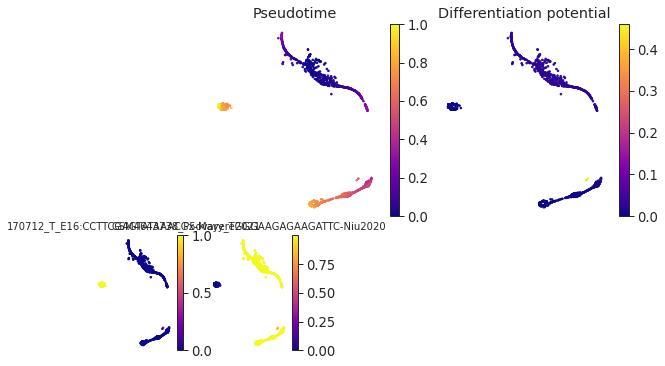

In [33]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()

## Gene expression trends

In [34]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

170712_T_E16:CCTTCGAGTATAAACGx-Mayere2021
Time for processing 170712_T_E16:CCTTCGAGTATAAACGx-Mayere2021: 0.3109386126200358 minutes
GSM4643738_P5ovary_TGGGAAGAGAAGATTC-Niu2020
Time for processing GSM4643738_P5ovary_TGGGAAGAGAAGATTC-Niu2020: 0.253207532564799 minutes


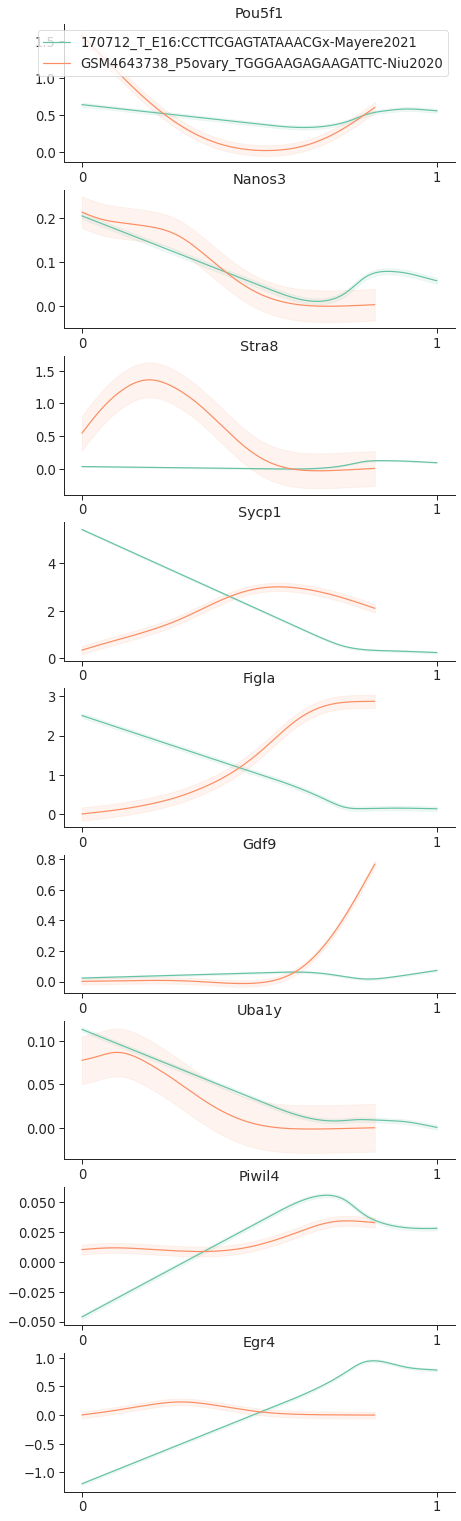

In [35]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

## Run palantir especifing endpoint as well

In [36]:
index, value = max(enumerate(adata[:,'Nanog'].X), key=operator.itemgetter(1))
PGC = adata.obs.index[index]
PGC

index, value = max(enumerate(adata[:,'Figla'].X), key=operator.itemgetter(1))
oocyte = adata.obs.index[index]
oocyte


index, value = max(enumerate(adata[:,'Egr4'].X), key=operator.itemgetter(1))
gonocyte = adata.obs.index[index]
gonocyte

'170313_T_E16:AAAGCAAGTTCAGTACx-Mayere2021'

In [37]:
terminal_states = pd.Series(['pre_spermatogonia', 'oocyte'], index=[ gonocyte, oocyte])
pr_res = palantir.core.run_palantir(ms_data, PGC, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.009905481338500976 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.3712582270304362 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [38]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

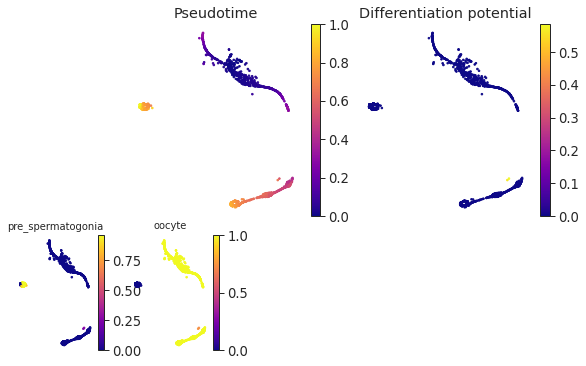

In [45]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
fig.savefig('figures_germcells/plot_palantir_resultsEndpoint.pdf', dpi=1200)

In [40]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

pre_spermatogonia
Time for processing pre_spermatogonia: 0.04723790884017944 minutes
oocyte
Time for processing oocyte: 0.029648534456888833 minutes


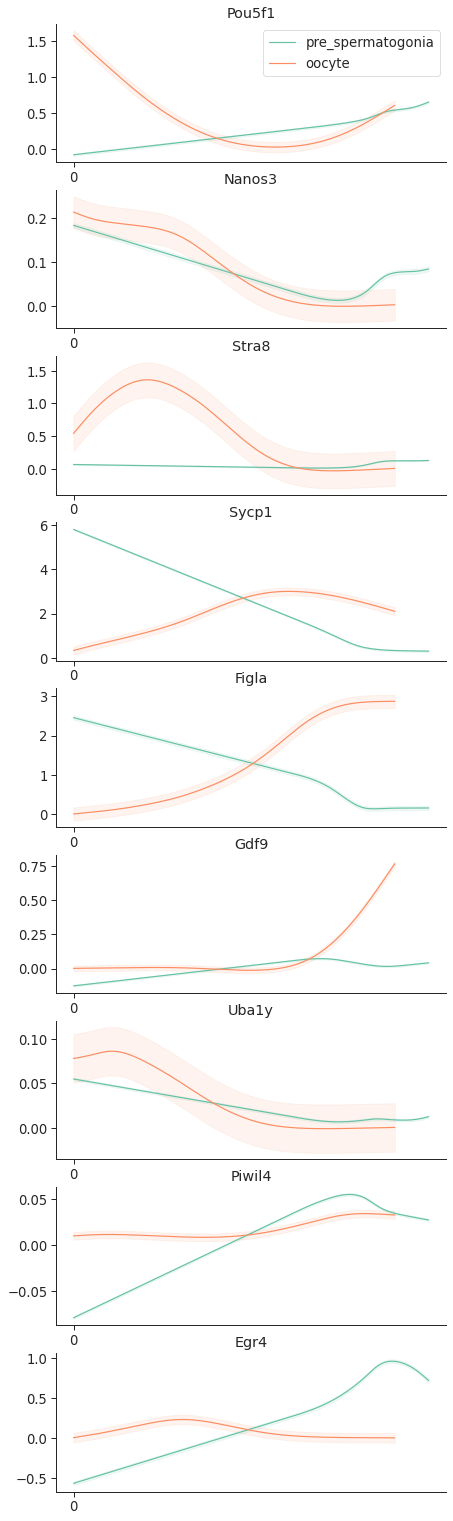

In [41]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

# Clustering

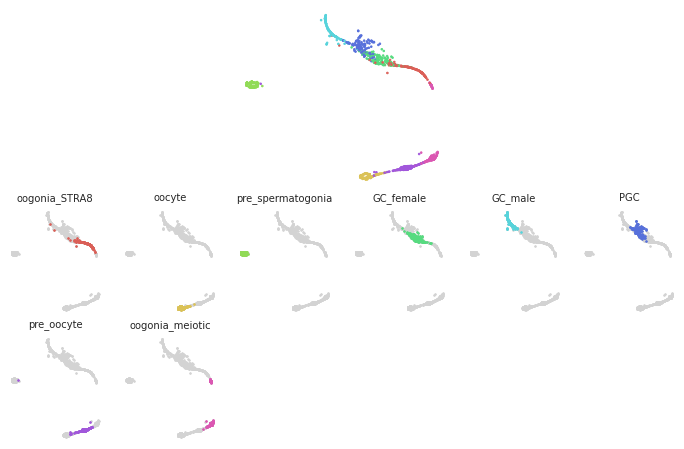

In [42]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
clusters = adata.obs['celltype']

palantir.plot.plot_cell_clusters(tsne, clusters)
fig = plt.gcf()
fig.savefig('figures_germcells/plot_palantir_celltypes.pdf', dpi=1200)



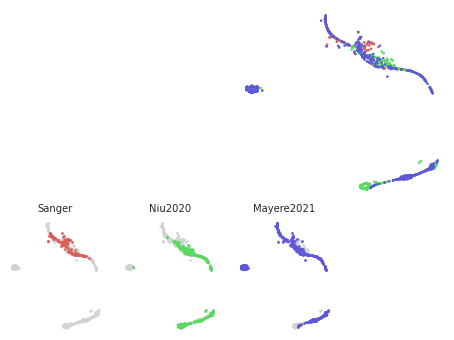

In [43]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
clusters = adata.obs['dataset']

palantir.plot.plot_cell_clusters(tsne, clusters)
fig = plt.gcf()
fig.savefig('figures_germcells/plot_palantir_dataset.pdf', dpi=1200)



In [44]:
adata.write('trj_palantir1_germcells.h5ad')